# Load libraries and data

In [17]:
from pathlib import Path
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score

In [18]:
train_data = pd.read_csv(Path("..", "data", "processed", "train.csv"))
val_data = pd.read_csv(Path("..", "data", "processed", "val.csv"))

# Parameters

In [19]:
MAX_LEN = 150
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
NUM_FILTERS = 128
KERNEL_SIZE = 3
DROPOUT = 0.3
LEARNING_RATE = 0.0008
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 6  # toxic, severe_toxic, obscene, threat, insult, identity_hate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


# Tokenizer

In [20]:
# Tokenizer (basic word splitting)
def basic_tokenizer(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    return text.split()


def build_vocab(texts):
    token_counts = Counter()
    for text in texts:
        cleaned_text = basic_tokenizer(text)
        token_counts.update(cleaned_text)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(token_counts.most_common())}  # Reserve index 0 for padding, 1 for unknown
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab


# Convert texts to numerical sequences
def encode_text(text, vocab, max_len=150):
    tokens = basic_tokenizer(text)
    encoded = [vocab.get(word, vocab["<UNK>"]) for word in tokens[:max_len]]
    return np.pad(encoded, (0, max_len - len(encoded)), constant_values=vocab["<PAD>"])[:max_len]

# Model

In [21]:
# Dataset Class
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=150):
        texts = [encode_text(text, vocab, max_len) for text in texts]
        self.texts = [torch.tensor(text, dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.texts[idx],
            "labels": self.labels[idx]
        }


# Model: CNN + GRU
class ToxicClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_filters, kernel_size, dropout, num_classes):
        super().__init__()
        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # CNN layer
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=1)
        self.pool = nn.AdaptiveMaxPool1d(50) # This reduces the sequence length
        # GRU layer
        self.gru = nn.GRU(
            input_size=num_filters,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True)
        # Fully connected layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1) # change shape for conv1d (batch_size, channels, seq_len)
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1) # change shape back for GRU (batch_size, seq_len, channels)
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :]) # take the last time step
        return self.fc(x)


# Training function
def model_train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)

    epochs_list = []
    train_loss_list = []
    train_roc_auc_list = []
    val_loss_list = []
    val_roc_auc_list = []

    for epoch in range(epochs):
        model.train()  # set model to training mode
        total_train_loss = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            outputs = torch.sigmoid(outputs)
            all_preds.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
        
        # Compute Loss
        train_loss = total_train_loss / len(train_loader)

        # Compute AUC_ROC
        all_preds = np.concatenate(all_preds, axis=0).T
        all_labels = np.concatenate(all_labels, axis=0).T
        train_roc_auc = np.mean(
            [roc_auc_score(y_true, y_pred) for y_true, y_pred in zip(all_labels, all_preds)]
        )

        # Validation Step
        model.eval()
        val_preds = []
        val_labels = []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                
                # Compute validation loss
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                val_preds.append(outputs.cpu().numpy())
                val_labels.append(labels.cpu().numpy())
        
        # Compute validation loss
        val_loss = total_val_loss / len(val_loader)

        # Compute AUC_ROC
        val_preds = np.concatenate(val_preds, axis=0).T
        val_labels = np.concatenate(val_labels, axis=0).T
        val_roc_auc = np.mean(
            [roc_auc_score(y_true, y_pred) for y_true, y_pred in zip(val_labels, val_preds)]
        )

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | AUC_ROC: {train_roc_auc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | AUC_ROC: {val_roc_auc:.4f}")

        epochs_list.append(epoch + 1)
        train_loss_list.append(train_loss)
        train_roc_auc_list.append(train_roc_auc)
        val_loss_list.append(val_loss)
        val_roc_auc_list.append(val_roc_auc)
        
    return {
        "epoch": epochs_list,
        "train_loss": train_loss_list,
        "train_roc_auc": train_roc_auc_list,
        "val_loss": val_loss_list,
        "val_roc_auc": val_roc_auc_list }

# Data

In [22]:
train_input = train_data.comment_text.to_list()
train_labels = train_data.loc[:, ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()

val_input = val_data.comment_text.to_list()
val_labels = val_data.loc[:,  ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()

vocab = build_vocab(train_input)

# Prepare train dataset
train_dataset = ToxicDataset(train_input, train_labels, vocab, MAX_LEN)

# Prepare validation dataset
val_dataset = ToxicDataset(val_input, val_labels, vocab, MAX_LEN)

# Train model

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
model = ToxicClassifier(
    len(vocab),
    EMBEDDING_DIM,
    HIDDEN_DIM,
    NUM_FILTERS,
    KERNEL_SIZE,
    DROPOUT,
    NUM_CLASSES)
model.to(DEVICE)
    
# Loss
criterion = nn.BCEWithLogitsLoss() # Multi-label loss
    
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
# Training loop
history = model_train(model, train_dataloader, val_dataloader, criterion, optimizer, EPOCHS, DEVICE)

Epoch 1/10
Train Loss: 0.0849 | AUC_ROC: 0.9058
Val Loss: 0.0622 | AUC_ROC: 0.9618
Epoch 2/10
Train Loss: 0.0548 | AUC_ROC: 0.9649
Val Loss: 0.0579 | AUC_ROC: 0.9713
Epoch 3/10
Train Loss: 0.0465 | AUC_ROC: 0.9746
Val Loss: 0.0552 | AUC_ROC: 0.9725
Epoch 4/10
Train Loss: 0.0411 | AUC_ROC: 0.9801
Val Loss: 0.0550 | AUC_ROC: 0.9730
Epoch 5/10
Train Loss: 0.0370 | AUC_ROC: 0.9841
Val Loss: 0.0593 | AUC_ROC: 0.9713
Epoch 6/10
Train Loss: 0.0333 | AUC_ROC: 0.9860
Val Loss: 0.0612 | AUC_ROC: 0.9712
Epoch 7/10
Train Loss: 0.0301 | AUC_ROC: 0.9887
Val Loss: 0.0714 | AUC_ROC: 0.9679
Epoch 8/10
Train Loss: 0.0283 | AUC_ROC: 0.9897
Val Loss: 0.0711 | AUC_ROC: 0.9659
Epoch 9/10
Train Loss: 0.0260 | AUC_ROC: 0.9911
Val Loss: 0.0733 | AUC_ROC: 0.9686
Epoch 10/10
Train Loss: 0.0241 | AUC_ROC: 0.9929
Val Loss: 0.0790 | AUC_ROC: 0.9651


In [25]:
def render_history(history):
  ep = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history["epoch"], history["train_loss"], label="Training loss")
  plt.plot(history["epoch"], history["val_loss"], label="Validation loss")
  plt.ylabel("Loss")
  plt.ylabel("Epochs (+1)")
  plt.legend(frameon=False)
  plt.subplot(1, 2, 2)
  plt.plot(history["epoch"], history["train_roc_auc"], label="Training ROC AUC")
  plt.plot(history["epoch"], history["val_roc_auc"], label="Validation ROC AUC")
  plt.ylabel("ROC AUC")
  plt.legend()
  plt.show()

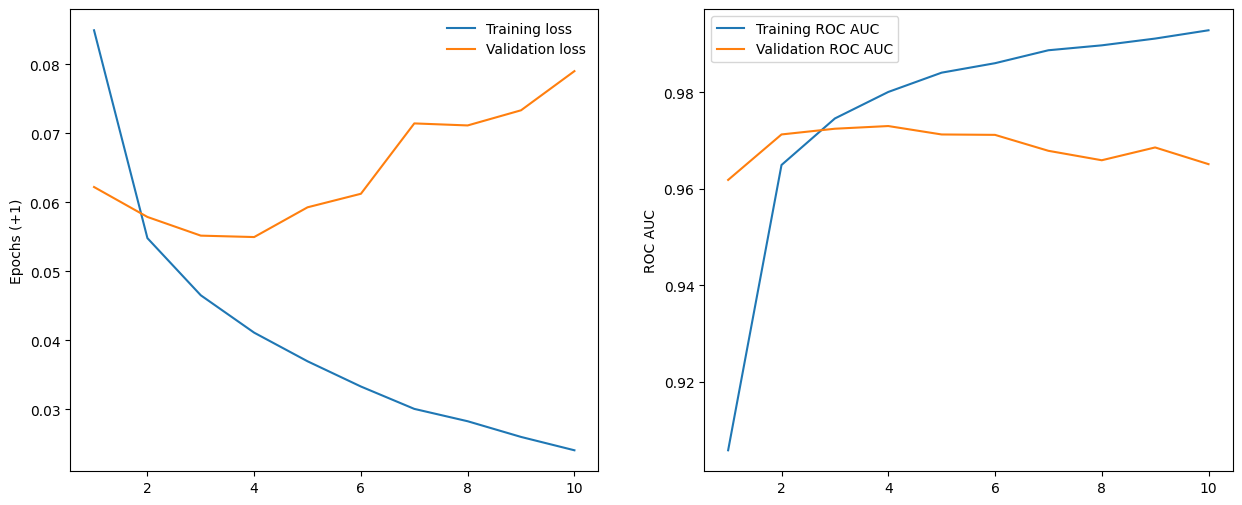

In [26]:
render_history(history)

# Retrain model

In [27]:
SELECTED_N_EPOCHS = 3

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
model = ToxicClassifier(
    len(vocab),
    EMBEDDING_DIM,
    HIDDEN_DIM,
    NUM_FILTERS,
    KERNEL_SIZE,
    DROPOUT,
    NUM_CLASSES)
model.to(DEVICE)
    
# Loss
criterion = nn.BCEWithLogitsLoss() # Multi-label loss
    
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
history = model_train(model, train_dataloader, val_dataloader, criterion, optimizer, SELECTED_N_EPOCHS, DEVICE)

Epoch 1/3
Train Loss: 0.0798 | AUC_ROC: 0.9196
Val Loss: 0.0615 | AUC_ROC: 0.9638
Epoch 2/3
Train Loss: 0.0539 | AUC_ROC: 0.9667
Val Loss: 0.0554 | AUC_ROC: 0.9708
Epoch 3/3
Train Loss: 0.0461 | AUC_ROC: 0.9759
Val Loss: 0.0524 | AUC_ROC: 0.9737


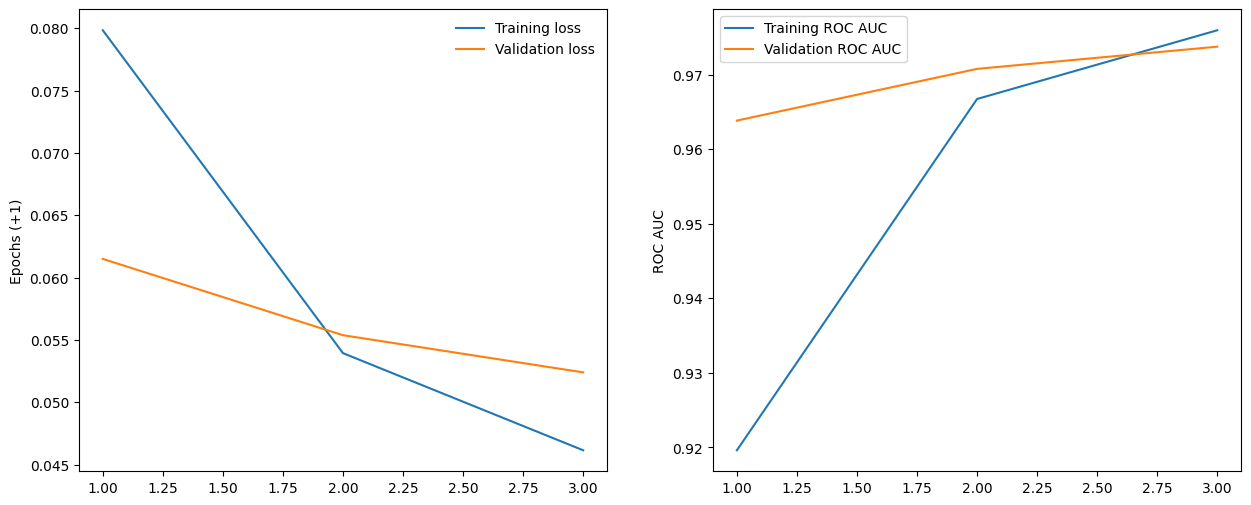

In [28]:
render_history(history)

# Save model and files

This model is saved locally but not on GitHub. It was only used to evaluate performance

In [29]:
# Save Model Weights
torch.save(model.state_dict(), "../model/model_no_pretrained.pth")

# Save Vocabulary 
json.dump(vocab, open("../model/vocab_no_pretrained.json", "w"))

# Save Tokenizer
# see script in utils

# Save Hyperparameters
# (to recreate the model architecture)
config = {
    "vocab_size": len(vocab),
    "embedding_dim": EMBEDDING_DIM,
    "hidden_dim": HIDDEN_DIM,
    "num_filters": NUM_FILTERS,
    "kernel_size": KERNEL_SIZE,
    "dropout": DROPOUT,
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "max_len": MAX_LEN,
    "num_classes": NUM_CLASSES  # toxic, severe_toxic, obscene, threat, insult, identity_hate
}
json.dump(config, open("../model/config_no_pretrained.json", "w"))
